We are going to do a quick exercise mapping sea level rise and its impact on our buildings, roads, etc.

make sure you have installed these libraries:

- ipyleaflet
- netcdf4
- Folium

In [84]:
import sys, os
import rasterio
from rasterio import features
import matplotlib.pyplot as plt
import folium
sys.path.append(os.path.abspath('..')) # set default directory where this notebook is running from
#pip install --upgrade ipykernel ## just to get rid of deprecation warnings

In [85]:
pip install --upgrade ipykernel

Note: you may need to restart the kernel to use updated packages.


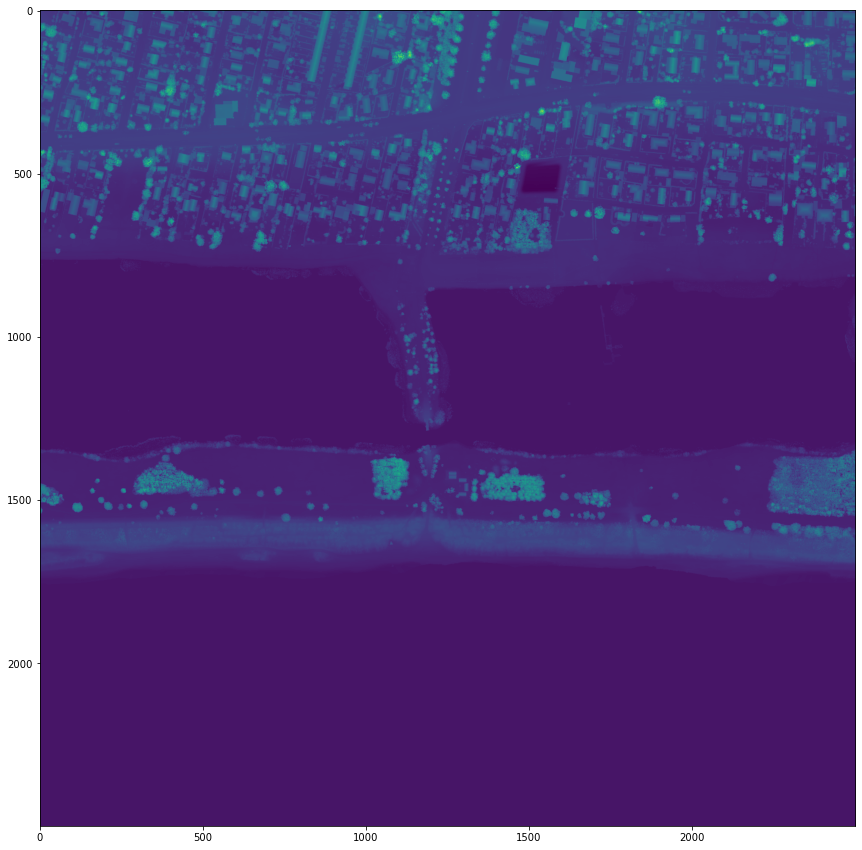

In [86]:
# let's load the DSM data of the area
with rasterio.open('Data2022/DSM_1km_6168_715.tif') as dataset:
    dem=dataset.read(1)
    plt.figure(figsize=(15, 15))
    imgplot = plt.imshow(dem)

In [87]:
# we load the sea level rise layer for Brøndby Strand area, note that 190cm in the layer name indicates the level of SLR for 190cm water level increase
fp='Data2022/hav190cm_960_clip.tif'
raster = rasterio.open(fp)

In [88]:
# let's print the metadata of the file
metadata=raster.meta
print(metadata)

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': 2147483647.0, 'width': 1091, 'height': 963, 'count': 1, 'crs': CRS.from_epsg(3044), 'transform': Affine(9.600161594867119, 0.0, 710852.9524,
       0.0, -9.603062201453797, 6175000.7286)}


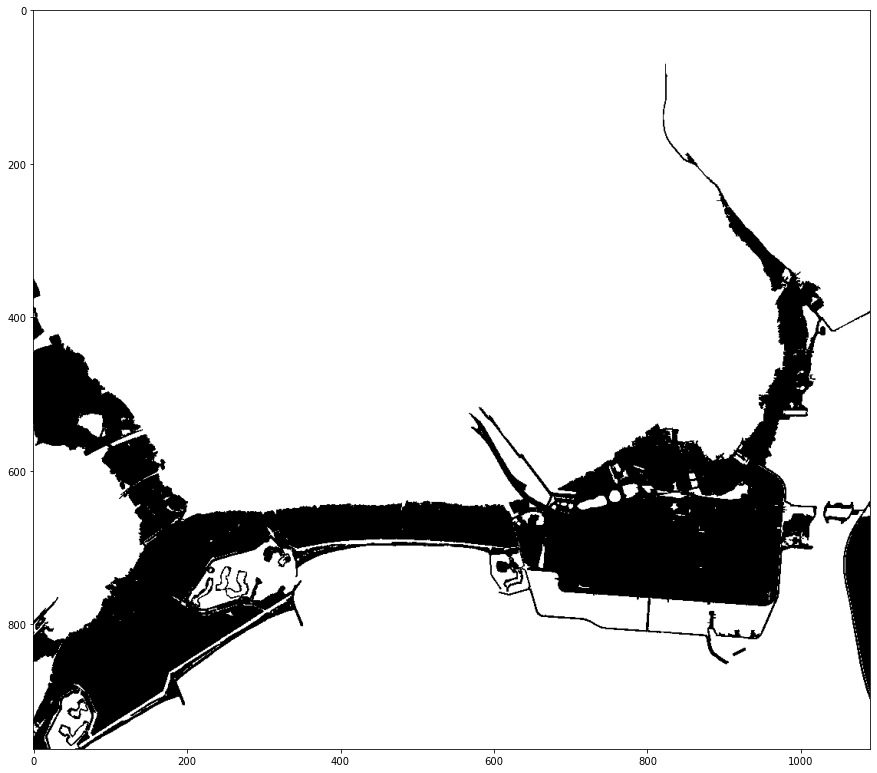

In [89]:
# let's plot our raster layer
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))

plt.imshow(raster.read(1), cmap="gray")
plt.show()

In [90]:
# since we are going to overlay the flooded areas with buildings, etc later, let's vectorize the raster layer using GDAL

from osgeo import gdal, ogr

sourceRaster = gdal.Open("Data2022/hav190cm_960_clip.tif")
band = sourceRaster.GetRasterBand(1)
bandArray = band.ReadAsArray()
outShapefile = "hav190_polygon"
driver = ogr.GetDriverByName("ESRI Shapefile")
if os.path.exists(outShapefile+".shp"):
    driver.DeleteDataSource(outShapefile+".shp")
outDatasource = driver.CreateDataSource(outShapefile+ ".shp")
outLayer = outDatasource.CreateLayer("hav190_polygon", srs=None)

newField = ogr.FieldDefn('MYFLD', ogr.OFTInteger)
outLayer.CreateField(newField)
gdal.Polygonize(band, None, outLayer, 0, [], callback=None )

outDatasource.Destroy()
sourceRaster = None

In [91]:
# let's import the layer we just exported in the cell above
import geopandas as gpd
df= gpd.read_file('hav190_polygon.shp')

/Users/jamal/opt/anaconda3/envs/GC/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


<AxesSubplot:>

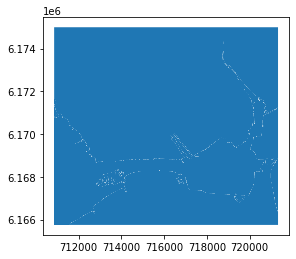

In [92]:
# a quicklook of the geodataframe
%matplotlib inline 

df.plot()

In [114]:
# since all raster cells were converted to vector, I put this thereshold after a dozen of tries to filter the irrelevant pixels
df=df.loc[df['MYFLD']<=10000]

<AxesSubplot:>

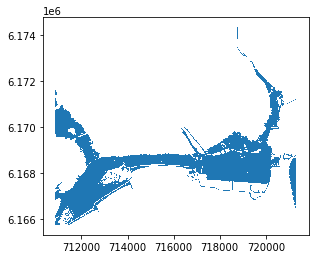

In [115]:
# a quicklook of the geodataframe
%matplotlib inline 

df.plot()

we are going to extract some data from openstreetmap through OSMnx library. it makes it a lot easier to retrive geodata

/Users/jamal/opt/anaconda3/envs/GC/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
/Users/jamal/opt/anaconda3/envs/GC/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


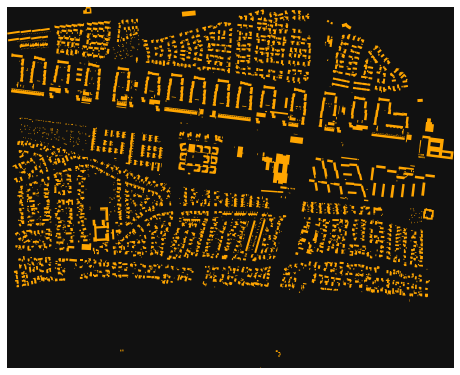

In [95]:
# Retrieve the buildings footprint of the address
import osmnx as ox

# specifying the target area's address 
place_adr="Brøndby Strand"

# specifying the target tags e.g., buildings 
tags = {'building': True}

# Retrieve buildings from the area within 1000 distance
buildings = ox.geometries_from_address(place_adr, tags, dist=1000)

fig, ax = ox.plot_footprints(buildings)

In [96]:
buildings.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [97]:
from fiona.crs import from_epsg 

# Set the GeoDataFrame's coordinate system to UTM32N: epsg code 3044 
df.crs = from_epsg(3044) 

/Users/jamal/opt/anaconda3/envs/GC/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [98]:
print(df.crs)

+init=epsg:3044 +no_defs +type=crs


let's project to df's projection which is UTM32N

In [99]:
build_new = buildings.to_crs(df.crs)

let's extract the flooded areas with the existing buildings within it by a simple overlaying function called 'intersecion'

In [116]:
inters = gpd.overlay(df, build_new, how='intersection')

/Users/jamal/opt/anaconda3/envs/GC/lib/python3.7/site-packages/geopandas/_vectorized.py:772: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  for geom in data
/Users/jamal/opt/anaconda3/envs/GC/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
/Users/jamal/opt/anaconda3/envs/GC/lib/python3.7/site-packages/geopandas/_vectorized.py:299: DeprecationWarning: An exception was ignored while fetchin

In [101]:
inters

,MYFLD,nodes,building,building:levels,layer,abandoned,created_by,amenity,name,opening_hours,...,shop,source,email,phone,bicycle_parking,covered,roof:levels,ways,type,geometry
0,0,"[6192024085, 6192021451, 6191990487, 619203826...",yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((715797.036 6168854.769, 715794.403 6..."
1,6,"[6192024085, 6192021451, 6191990487, 619203826...",yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((715797.036 6168854.769, 715797.036 6..."
2,4,"[6192024085, 6192021451, 6191990487, 619203826...",yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((715806.636 6168854.769, 715806.636 6..."
3,3,"[6192024085, 6192021451, 6191990487, 619203826...",yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((715807.937 6168854.769, 715807.399 6..."
4,6,"[6192024470, 6192021836, 6191990873, 619203915...",yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((715547.431 6168847.878, 715546.470 6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,59,"[4126361819, 4126361811, 4126361812, 412636182...",yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((714750.618 6168393.822, 714750.618 6..."
1432,64,"[4126361819, 4126361811, 4126361812, 412636182...",yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((714750.618 6168393.822, 714750.618 6..."
1433,67,"[4126361819, 4126361811, 4126361812, 412636182...",yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((714754.034 6168393.822, 714754.239 6..."
1434,29,"[1781335913, 1781335884, 1781335909, 1781335913]",yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((715432.229 6168345.806, 715432.229 6..."


<AxesSubplot:>

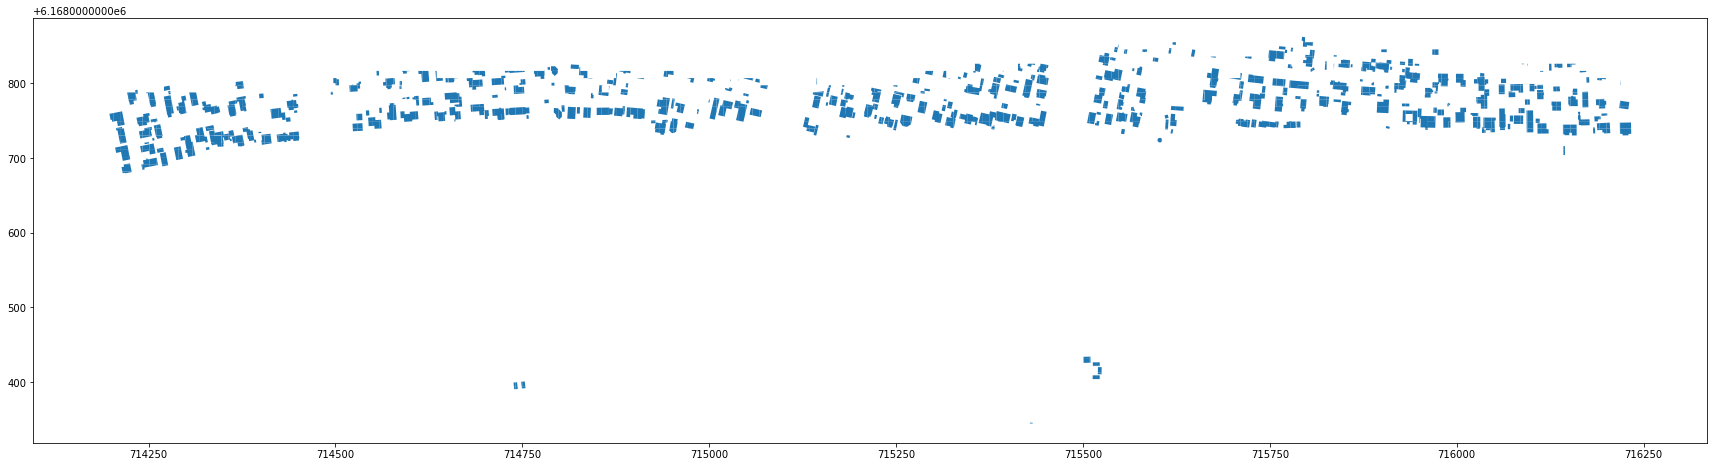

In [102]:
# a quicklook of the geodataframe
%matplotlib inline 

inters.plot(figsize=(30,15))

let's explore which streets/roads will be flooded and hence must be uplifted

In [103]:
#let's extract road network from the osmnx graph made for streets
roads = ox.graph_from_address(place_adr)


/Users/jamal/opt/anaconda3/envs/GC/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
/Users/jamal/opt/anaconda3/envs/GC/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


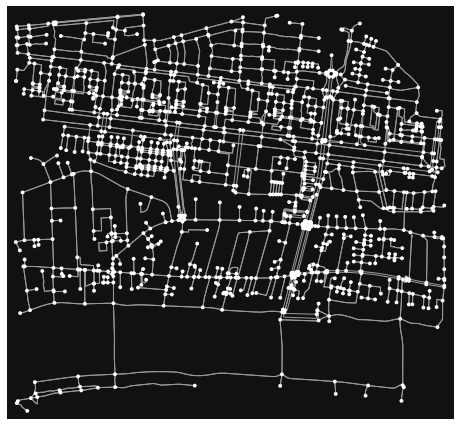

In [104]:
# let's plot the graph
fig, ax = ox.plot_graph(roads)


In [105]:
# the graph will be converted to two geodataframes of nodes and edges
nodes, edges = ox.graph_to_gdfs(roads)


<AxesSubplot:>

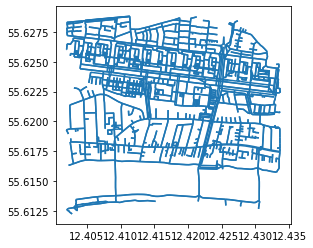

In [106]:
# the edge geodataframe contains the roads geometries
edges.plot()

In [107]:
# let's project it to UTM32N
roads_new = edges.to_crs(df.crs)

In [108]:
type(df)

geopandas.geodataframe.GeoDataFrame

In [109]:
# let's intersect it with the flooded polygons
f_roads = gpd.overlay(roads_new, df, how='intersection')

/Users/jamal/opt/anaconda3/envs/GC/lib/python3.7/site-packages/geopandas/_vectorized.py:772: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  for geom in data
/Users/jamal/opt/anaconda3/envs/GC/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
/Users/jamal/opt/anaconda3/envs/GC/lib/python3.7/site-packages/geopandas/_vectorized.py:299: DeprecationWarning: An exception was ignored while fetchin

In [110]:
f_roads

,osmid,oneway,lanes,ref,name,highway,maxspeed,length,junction,bridge,service,tunnel,width,access,MYFLD,geometry
0,"[34039360, 304702729]",False,NaN,NaN,Hyldestien,"[cycleway, path]",NaN,54.894,NaN,NaN,NaN,NaN,NaN,NaN,9,"LINESTRING (716015.781 6168835.563, 716015.659..."
1,"[34039360, 304702729]",False,NaN,NaN,Hyldestien,"[cycleway, path]",NaN,54.894,NaN,NaN,NaN,NaN,NaN,NaN,9,"LINESTRING (716015.659 6168825.960, 716015.781..."
2,"[34039360, 304702729]",False,NaN,NaN,Hyldestien,"[cycleway, path]",NaN,54.894,NaN,NaN,NaN,NaN,NaN,NaN,18,"LINESTRING (716015.659 6168825.960, 716015.595..."
3,304702729,False,NaN,NaN,Hyldestien,cycleway,NaN,127.751,NaN,NaN,NaN,NaN,NaN,NaN,18,"LINESTRING (716015.665 6168816.357, 716015.595..."
4,25829637,False,2,NaN,Holmesøvej,residential,50,18.751,NaN,NaN,NaN,NaN,NaN,NaN,18,"LINESTRING (716008.239 6168822.213, 716015.595..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594,839588292,False,NaN,NaN,NaN,service,NaN,31.455,NaN,NaN,driveway,NaN,NaN,NaN,88,"LINESTRING (715631.833 6168744.907, 715631.168..."
2595,839588292,False,NaN,NaN,NaN,service,NaN,31.455,NaN,NaN,driveway,NaN,NaN,NaN,73,"LINESTRING (715629.979 6168729.929, 715631.168..."
2596,839588292,False,NaN,NaN,NaN,service,NaN,31.455,NaN,NaN,driveway,NaN,NaN,NaN,73,"LINESTRING (715631.168 6168739.532, 715629.979..."
2597,839588292,False,NaN,NaN,NaN,service,NaN,31.455,NaN,NaN,driveway,NaN,NaN,NaN,54,"LINESTRING (715628.790 6168720.326, 715629.979..."


<AxesSubplot:>

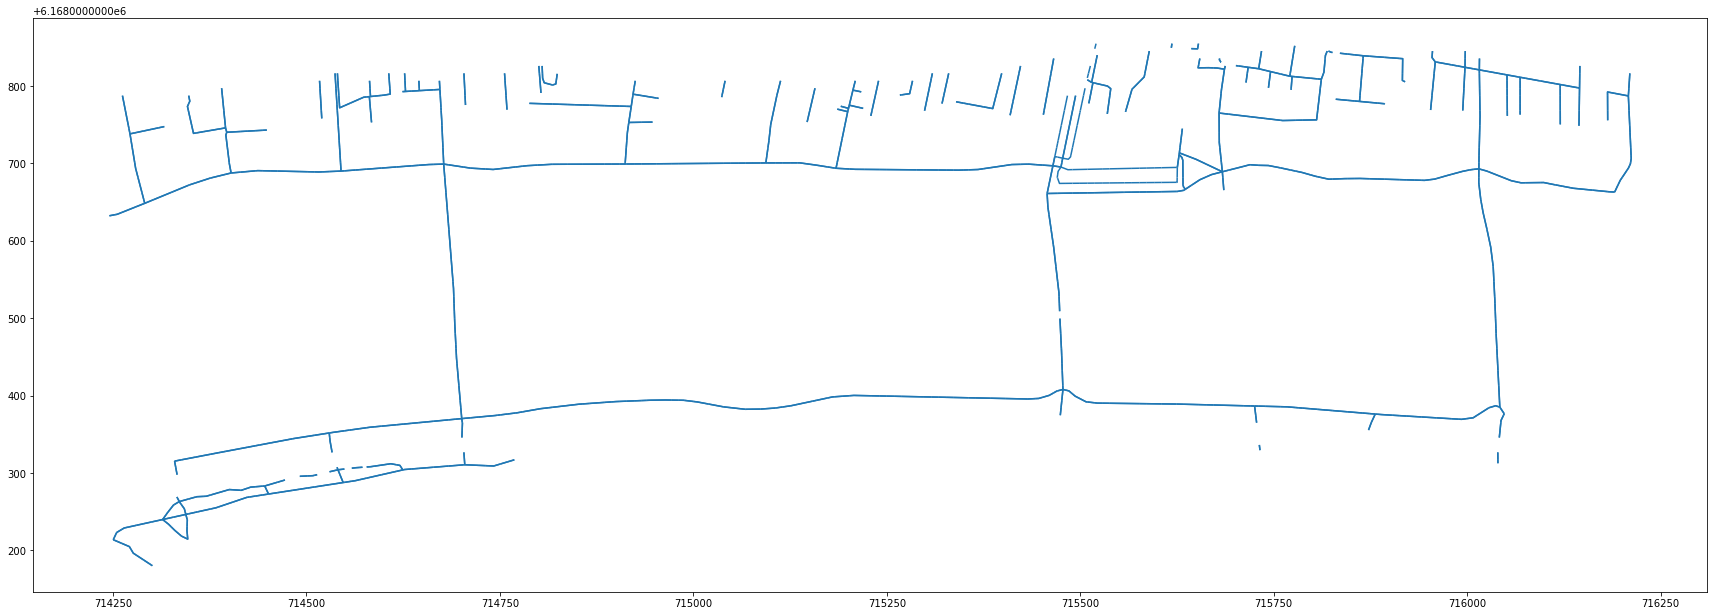

In [111]:
# a quicklook of the geodataframe
%matplotlib inline 

f_roads.plot(figsize=(30,15))

In [112]:
# Convert roads  to GeoJson
res_gjson = folium.features.GeoJson(f_roads, name = "roads")


In [113]:
# Create a Map instance
m = folium.Map(location=[55.62343, 12.43141], tiles = 'Stamen Toner', zoom_start=14, control_scale=True)

# Add points to the map instance
res_gjson.add_to(m)

# Alternative syntax for adding points to the map instance
#m.add_child(res_gjson)

#Show map
m

## Would you like to dig more into interactive maps?


[Ipyleaflet](https://github.com/jupyter-widgets/ipyleaflet) is also another great library for making interactive maps. Better try it out on your own. Some materials [here](https://github.com/jupyter-widgets/ipyleaflet)



Here are a few examples and interesting controls that you can add to your map

In [117]:
# let's import some classes of ipyleaflet
from ipyleaflet import Map, basemaps, basemap_to_tiles

# we create a map instance just like we did with folium

m = Map(
    layers=(basemap_to_tiles(basemaps.NASAGIBS.ModisTerraTrueColorCR, "2021-6-20"), ),
    center=(53.204793, 12.121558),
    zoom = 6
)

m

Map(center=[53.204793, 12.121558], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [118]:
m

Map(bottom=5522.0, center=[53.204793, 12.121558], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

### Note the basemap is a satellite image from [Modis-Terra](https://modis.gsfc.nasa.gov/about/)

In [119]:
# in this exmaple, you can make a split map showing two different kinds of basemaps, left: ESRI world imagery, 
# Right:Modis-Terra

from ipyleaflet import Map, basemaps, basemap_to_tiles, SplitMapControl, FullScreenControl

#create map instance with center point and zoom level
m = Map(center=(42.6824, 365.581), zoom=5)

# set right and left windows' content, you can set the date of the image. Good luck to find a cloud free image
right_layer = basemap_to_tiles(basemaps.NASAGIBS.ModisTerraTrueColorCR, "2019-07-11")
left_layer = basemap_to_tiles(basemaps.Esri.WorldImagery)

# add split control
control = SplitMapControl(left_layer=left_layer, right_layer=right_layer)
m.add_control(control)

# add full screen control
m.add_control(FullScreenControl())

# show the map
m

Map(center=[42.6824, 365.581], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

``GeoData`` is an ``ipyleaflet`` class that allows you to visualize a GeoDataFrame on the Map.



####  If you would like to visualize velocity related data e.g. wind, cars movement, trajectories, etc. you can learn from the following example

If you have a moving object or trajectory data e.g., your trip from CPH airport to your home in Odense, this can help

In [120]:
from ipyleaflet import Map, AntPath

m = Map(center=(55.674465, 12.567415), zoom=8)

ant_path = AntPath(
    locations=[
        [55.623860, 12.652274], [55.666958, 12.611342], [55.680469, 12.604686], [55.714883, 12.577731],
        [55.680094, 12.538463], [55.674465, 12.567415], [55.657935, 12.276470], [55.631540, 12.055273],
        [55.461196, 11.796074], [55.411995, 11.361476], [55.332814, 10.964881], [55.298990, 10.837230],
        [55.392630, 10.389965]
    ],
    dash_array=[1, 10],
    delay=1000,
    color='#7590ba',
    pulse_color='#3f6fba'
)

m.add_layer(ant_path)

m

Map(center=[55.674465, 12.567415], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…